In [737]:
import torch 
import spacy
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
#from datasets import load_datasets
from typing import Iterable, List
from torch.utils.data import DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [738]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

The chunk of code below loads in the data as well as a data tokenizer to split the data into tokens or language elements like words punctuation and grammar. We also need to define other special tokens such as BOS, EOS, UNK and PAD which will themselves are very important to ensure the model can fit into a tensor as well as follows the necessary requirements of the architecture (such as right shift). The last part of the code builds the vocab object, a bit like a dictionary but it also stores the special tokens and punctuation of the language. 

In [739]:
#TAKEN FROM PYTORCH WEBSITE 

multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}

#The tokenizer just breaks sentences up into tokens i.e. words, punctuation etc. This code is downloading the tokenizer from spacy
token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")
token_transform[TGT_LANGUAGE] = get_tokenizer("spacy", language="de_core_news_sm")

#Converts a sentence into its tokens 
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        tokenizer = token_transform[language]
        yield tokenizer(data_sample[language_index[language]])

# Define special symbols and their indices in the vocab list 
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


#BULDING THE VOCAB
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    #Creates the vocab object inside vocab_transform and places the special tokens first in their index order
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)


We now need to be able to use the data, taking it from a batch of sentences and converting it into tensors. This includes adding the special tokens where necessary (primarily this is the EOS and BOS tokens), we then need to PAD so that all sentence lengths are the same length as the longest length of the batch. Lastly we need to convert these sentences into tensors bu first tokenising and then embedding. Once that is all complete we are ready to start running the data through the model. 


In [740]:
from torch.nn.utils.rnn import pad_sequence 

# Joins multiple transformations on the dataset
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

#function to add BOS/EOS and create tensor. The inputs are the index inside the vocab object 
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]: #"en" of "de" in our case 
    #creates dictionary entries with code "en" or "de" with value equal to 
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization (vocab_transform[SRC_language]["on"] will return the index in the vocab object
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors which are ready for the model, 
# this function is passed directly into the dataloader 
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.transpose(0,1), tgt_batch.transpose(0,1)



The last part of dealing with the data is that we require a masking function so that the model isnt looking ahead so to speak. 

In [741]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) #-inf on upper diagonal and 0 elsewhere
    return mask


def create_mask(src, tgt, batch_size):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    #Mask tensor 
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    #Tensor of False because we dont mask the source sequence for our purpose however if you use the transformer package, 
    # from pytorch it expects a masking argument. 
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    #Coloumn vector of Trues where padding occurs and False otherwise since we dont want to attend to these positions,
    #they dont tell us any new information. 
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)[:, None, :].expand(batch_size,tgt_seq_len,tgt_seq_len)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

It might be worth also testing en_core_web_md the md meaning "medium" instead of small which uitilises word vectors unlike the current download. 
this can be done using 
python3.11 -m spacy download en_core_web_md
python3.11 -m spacy download de_core_news_md

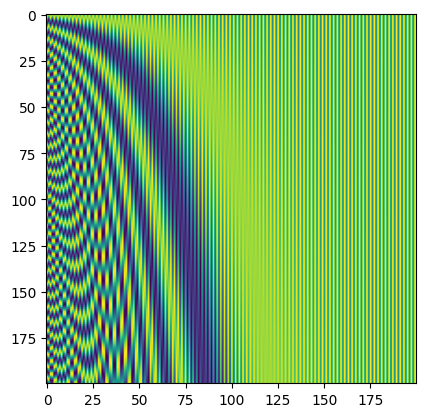

In [742]:
#COMPLETED ENTIRELY INDEPENDENTLY 

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
import matplotlib.pyplot as plt 
import numpy as np
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#The input embedding is then the vectorised text sequence. 
#The embedding module creates and stores the word embeddings in a useful way that are accesible via indices
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    
    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)


class PositionalEncoding(nn.Module):
    "Compute Sinusoidal Positional Encoding"
    def __init__(self):
        super().__init__()
    
    def forward(self, dim):
        #POS is the position in the sentence 
        #d_model is the dimension in the encoded space 
        PE = torch.zeros((dim[1], dim[-1]))
        d_model = dim[-1]
        pos = dim[1]
        PE += torch.arange(pos).unsqueeze(1)
        i_vec_sin = torch.arange(0, d_model, 2)/d_model
        i_vec_cos = torch.arange(1, d_model, 2)/d_model
        PE[:, ::2] = torch.sin(torch.exp(torch.log(PE[:, ::2]) - i_vec_sin * np.log(10000)))
        PE[:, 1::2] = torch.cos(torch.exp(torch.log(PE[:, 1::2]) - i_vec_cos * np.log(10000)))
        return PE.expand(dim[0], -1, -1)
    
A = PositionalEncoding()
b = A((200, 200))
plt.imshow(b[0, :, :])        

In [743]:
#Single layer of attention 
class SelfAttention(nn.Module):
    def __init__(self, d_model: int, d_k: int):
        """
        d_model -> Embedding space
        d_k -> d_model/h where h is the number of heads of the MultiHead Attention 
        """
        super(SelfAttention, self).__init__()
        self.wq = nn.Linear(d_model, d_k, device=DEVICE)
        self.wk = nn.Linear(d_model, d_k, device=DEVICE)
        self.wv = nn.Linear(d_model, d_k, device=DEVICE)
        self.dmodel = d_model
        self.dk = d_k
        self.smax = nn.Softmax(-1)

    def forward(self, x, x_padding_mask):
        """
        
        x -> input tensor (generally word sequence)
        x_padding_mask -> padding mask for src
        """
        #Self-Attention
        x_padding_mask = x_padding_mask[:, None, :].expand(x.size()[0],x.size()[1],x.size()[1])
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        score = q @ k.transpose(1,2) / np.sqrt(self.dk)
        out = self.smax(score + x_padding_mask) @ v
        return out, score
    
class CrossAttention(nn.Module):
    def __init__(self, d_model: int, d_k: int):
        """
        d_model -> Embedding space
        d_k -> d_model/h where h is the number of heads of the MultiHead Attention 
        """
        super(CrossAttention, self).__init__()
        self.wq = nn.Linear(d_model, d_k, device=DEVICE)
        self.wk = nn.Linear(d_model, d_k, device=DEVICE)
        self.wv = nn.Linear(d_model, d_k, device=DEVICE)
        self.dmodel = d_model
        self.dk = d_k
        self.smax = nn.Softmax(-1)


    def forward(self, x, x_padding_mask, y):
        """
        
        x -> input tensor (generally word sequence)
        x_padding_mask -> padding mask for src
        """
        #Self-Attention
        q = self.wq(y)
        k = self.wk(x)
        v = self.wv(x)
        x_padding_mask = x_padding_mask[:, None, :].expand(x.size()[0],y.size()[1],x.size()[1])
        score = q @ k.transpose(1,2) / np.sqrt(self.dk)
        out = self.smax(score + x_padding_mask) @ v
        return out, score

#Single layer of attention 
class MaskedAttention(nn.Module):
    def __init__(self, d_model: int, d_k: int):
        """
        d_model -> Embedding space
        d_k -> d_model/h where h is the number of heads of the MultiHead Attention 
        """
        super(MaskedAttention, self).__init__()
        self.wq = nn.Linear(d_model, d_k, device=DEVICE)
        self.wk = nn.Linear(d_model, d_k, device=DEVICE)
        self.wv = nn.Linear(d_model, d_k, device=DEVICE)
        self.dmodel = d_model
        self.dk = d_k
        self.smax = nn.Softmax(-1)

    def forward(self, y, y_mask, y_padding_mask):
        """
        
        x -> input tensor (generally word sequence)
        x_padding_mask -> padding mask for src
        other arguments -> tgt, tgt mask, tgt padding mask 
        """

        #In a self attention block x=y, in the encoder-decoder attention only the keys and values come from the encoder output
        #Encoder-Decoder Attention - needs to apply masking of output
        q = self.wq(y)
        k = self.wk(y)
        v = self.wv(y)

        score = q @ k.transpose(1,2) / np.sqrt(self.dk)
        out = self.smax(score + y_mask + y_padding_mask) @ v
        return out, score


In [744]:
#Multi-Head Attention 
#h is the number of heads that we will use (same letter as used in the paper)

class MultiHeadSA(nn.Module):
    def __init__(self, h: int, d_model: int):
        """
        h -> number of heads 
        d_model -> dimension of the model embedding
        """
        super(MultiHeadSA, self).__init__()
        self.dk = int(d_model / h)
        self.dmodel = d_model 
        self.h = h
        self.weights = nn.ModuleList([SelfAttention(self.dmodel, self.dk) for _ in range(self.h)])
        self.W = nn.Linear(self.dmodel, self.dmodel)

    def forward(self, x, x_padding_mask):
        outputs = []
        for attention_layer in self.weights:
            out, score = attention_layer(x, x_padding_mask)
            outputs.append(out)
        concat_output = outputs[0]
        for i in outputs[1:]:
            concat_output = torch.cat((concat_output, i), 2)
        return concat_output
    
#Multi-Head Attention 
#h is the number of heads that we will use (same letter as used in the paper)

class MultiHeadCA(nn.Module):
    def __init__(self, h: int, d_model: int):
        """
        h -> number of heads 
        d_model -> dimension of the model embedding
        """
        super(MultiHeadCA, self).__init__()
        self.dk = int(d_model / h)
        self.dmodel = d_model 
        self.h = h
        self.weights = nn.ModuleList([CrossAttention(self.dmodel, self.dk) for _ in range(self.h)])
        self.W = nn.Linear(self.dmodel, self.dmodel)

    def forward(self, x, x_padding_mask, y):
        outputs = []
        for attention_layer in self.weights:
            out, score = attention_layer(x, x_padding_mask, y)
            outputs.append(out)
        concat_output = outputs[0]
        for i in outputs[1:]:
            concat_output = torch.cat((concat_output, i), 2)
        return concat_output
    

#Multi-Head Attention 
#h is the number of heads that we will use (same letter as used in the paper)

class MultiHeadMA(nn.Module):
    def __init__(self, h: int, d_model: int):
        """
        h -> number of heads 
        d_model -> dimension of the model embedding
        """
        super(MultiHeadMA, self).__init__()
        self.dk = int(d_model / h)
        self.dmodel = d_model 
        self.h = h
        self.weights = nn.ModuleList([MaskedAttention(self.dmodel, self.dk) for _ in range(self.h)])
        self.W = nn.Linear(self.dmodel, self.dmodel)

    def forward(self, y, y_mask, y_padding_mask):
        outputs = []
        for attention_layer in self.weights:
            out, score = attention_layer(y, y_mask, y_padding_mask)
            outputs.append(out)
        concat_output = outputs[0]
        for i in outputs[1:]:
            concat_output = torch.cat((concat_output, i), 2)
        return concat_output

In [745]:
#FeedForward Neural Network

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_hidden: int):
        super(FeedForward, self).__init__()
        self.layer1 = nn.Linear(d_model, d_hidden, device=DEVICE)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(d_hidden, d_model, device=DEVICE)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x 

In [746]:
class Encoder(nn.Module):
    def __init__(self, h: int, d_model: int, d_hidden):
        """
        h -> Number of Attention heads
        d_model -> Dimension of the embedding space 
        d_hidden -> Number of hidden layers in the feedforward network
        """
        super(Encoder, self).__init__()
        self.mha = MultiHeadSA(h, d_model)
        self.ffn = FeedForward(d_model, d_hidden)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.h = h
        
    def forward(self, x, x_padding_mask):
        """
        x -> Input 
        """
        x = x + self.mha(x, x_padding_mask)
        x = self.layernorm1(x)
        x = x + self.ffn(x)
        x = self.layernorm2(x)
        return x 

In [747]:
class Decoder(nn.Module):
    def __init__(self, h, d_model, d_hidden):
        super(Decoder, self).__init__()
        self.masked = MultiHeadMA(h, d_model)
        #eda - encoder- decoder attention
        self.ca = MultiHeadCA(h, d_model)
        self.ffn = FeedForward(d_model, d_hidden)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
    
    def forward(self, x, x_padding_mask, y, y_mask, y_padding_mask):
        """
        x -> Output from encoder 
        y -> target sequence 
        """
        y = y + self.masked(y, y_mask, y_padding_mask)
        y = self.layernorm1(y)
        y = y + self.ca(x, x_padding_mask, y)
        y = self.layernorm2(y)
        y = y + self.ffn(y)
        y = self.layernorm3(y)
        return y 

In [748]:
class Transformer(nn.Module):
    def __init__(self, h, N, d_model, d_hidden, src_vocab_size, tgt_vocab_size):
        """
        x -> Input sequence
        y -> Output sequence 
        h -> Number of heads 
        N -> Number of Encoder and Decoder layers 
        d_model -> Dimension of the model 
        d_hidden -> Number of hidden layers for the feed-forward model
        d_input -> Dimension of input (size of input language)

        """
        super(Transformer, self).__init__()
        self.EncoderLayers = nn.ModuleList()
        self.DecoderLayers = nn.ModuleList()
        for _ in range(N):
            self.EncoderLayers.append(Encoder(h, d_model, d_hidden))
            self.DecoderLayers.append(Decoder(h, d_model, d_hidden))
        self.Linearlayer = nn.Linear(d_model, tgt_vocab_size)
        self.smax = nn.Softmax(dim=-1)
        self.pe = PositionalEncoding()
        self.src_embed = TokenEmbedding(src_vocab_size, d_model)
        self.tgt_embed = TokenEmbedding(tgt_vocab_size, d_model)
        self.d_model = d_model
            
    def forward(self, x, x_padding_mask, y, y_mask, y_padding_mask):
        x = self.src_embed(x)
        y = self.tgt_embed(y)
        x = x.float()
        y = y.float()
        x = x + self.pe(x.size())
        y = y + self.pe(y.size())

        for encoder in self.EncoderLayers:
            x = encoder(x, x_padding_mask)
        for decoder in self.DecoderLayers:
            y = decoder(x, x_padding_mask, y, y_mask, y_padding_mask)
        y = y.view(-1, self.d_model)
        y = self.Linearlayer(y)
        return self.smax(y)



In [749]:
torch.manual_seed(0)
from tqdm import tqdm
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
d_hidden = 128
#Number of attention heads
h = 8
#Number of encoder and decoder layers - (this can be coded so that the number of encoder and decoder layers are different)
N = 4
d_model = 512
BATCH_SIZE = 100


transformer = Transformer(h, N, d_model, d_hidden, src_vocab_size, tgt_vocab_size)

#Initialise parameters 
for param in transformer.parameters():
    if param.dim() > 1:
        nn.init.xavier_uniform_(param)

transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)


In [750]:
optimiser = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Lets define the train function 

In [751]:


def train(model, optimiser):
    #inform the model that we are in training mode - this ensures dropout and batchnorm occur as expected 
    model.train()
    #initalise loss
    losses = 0
    #Data Loader
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        #We dont need an EOS token for the tgt hence up till -1
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, tgt_input.size()[0])
        output = model(src, src_padding_mask, tgt_input, tgt_mask, tgt_padding_mask)
        optimiser.zero_grad()
        tgt_out = tgt[:, 1:]
        tgt_out = tgt_out.reshape(-1)
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1).long())
        loss.backward()
        optimiser.step()
        losses += loss.item()

    return losses/len(list(train_dataloader))

In [784]:
def evaluate(model):
    model.eval() # sets the model into evaluate mode 
    losses = 0
    val_iter = Multi30k(split="valid", language_pair=(SRC_LANGUAGE,TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size = BATCH_SIZE, collate_fn = collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, tgt.size()[0])
        output = model(src, src_padding_mask, tgt_input, tgt_mask, tgt_padding_mask)
        tgt_out = tgt[:, 1:]
        tgt_out.reshape(-1)
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1).long())  
        losses += loss.item()

    return losses/len(list(val_dataloader))

        

In [753]:
num_epochs = 10 
train_losses = []
val_losses = []
for epoch in range(1, num_epochs+1):
    train_loss = train(transformer, optimiser)
    train_losses.append(train_loss)
    val_loss = evaluate(transformer)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch}, Train_loss: {train_loss}, Validation_loss = {val_loss}")

291it [10:11,  2.10s/it]


Epoch: 1, Train_loss: 9.757671503676582, Validation_loss = 9.695379603992809


291it [09:36,  1.98s/it]


Epoch: 2, Train_loss: 9.674144794031516, Validation_loss = 9.676389954306863


291it [12:24,  2.56s/it]


Epoch: 3, Train_loss: 9.65093868294942, Validation_loss = 9.655132553794168


291it [08:47,  1.81s/it]


Epoch: 4, Train_loss: 9.640806558615564, Validation_loss = 9.652352419766514


291it [08:39,  1.79s/it]


Epoch: 5, Train_loss: 9.617352102220673, Validation_loss = 9.619986013932662


291it [06:51,  1.41s/it]


Epoch: 6, Train_loss: 9.60292284595188, Validation_loss = 9.615175767378373


291it [07:10,  1.48s/it]


Epoch: 7, Train_loss: 9.600850865603313, Validation_loss = 9.613906080072576


291it [08:42,  1.79s/it]


Epoch: 8, Train_loss: 9.600425172917213, Validation_loss = 9.617151260375977


52it [01:37,  1.87s/it]


KeyboardInterrupt: 

In [823]:
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(DEVICE)

    tgt = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(tgt.size(0))
                    .type(torch.bool)).to(DEVICE)
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt, tgt.size()[0])

        output = model(src, src_padding_mask, tgt, tgt_mask, tgt_padding_mask)
        _, next_word = torch.max(output, dim=-1)
        next_word = next_word[-1]
        print(next_word)
        tgt = torch.cat([tgt,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return tgt


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    tgt_tokens = greedy_decode(
        model,  src, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")